# QS engine validation

In [79]:
import math as m
import numpy as np

electron_mass = 9.10938356e-31
elementary_charge = 1.6021766208e-19
speed_of_light = 299792458
reduced_plank = 1.054571800e-34
vacuum_permittivity =  8.854187817e-12
fine_structure_constant =  0.0072973525664

classical_elec_radius = (1./4./np.pi/vacuum_permittivity)*( elementary_charge**2 / (electron_mass * speed_of_light**2))

tau_e = classical_elec_radius/speed_of_light

lambda_laser = 1.0e-6

schwinger_field_SI = electron_mass**2 * speed_of_light**3 / (reduced_plank*elementary_charge)

schwinger_field_code_units = electron_mass*speed_of_light*lambda_laser/(2.0*reduced_plank*m.pi)

conversion_of_rate_from_code_to_SI = (2.0 * m.pi * speed_of_light)/lambda_laser

conversion_of_rate_from_SI_to_code = 1.0/conversion_of_rate_from_code_to_SI

field_reference_PIC = 2.0 * np.pi * electron_mass * speed_of_light * speed_of_light / (elementary_charge*lambda_laser)

qs_coeff = fine_structure_constant*fine_structure_constant/tau_e


In [80]:
def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p)  
    c = p/gamma_phot  
    loc_field = gamma_phot * np.linalg.norm( E - np.dot(c,E)*c + np.cross(c,B))     
    return loc_field/schwinger_field_code_units

def calc_chi_elec(p, E, B):
    gamma_elec = np.sqrt(1.0 + np.dot(p,p))
    v = p/gamma_elec
    evcb = E + np.cross(v,B)
    loc_field = gamma_elec * np.sqrt(np.abs(np.dot(v,E)**2 - np.dot(evcb,evcb)))
    return loc_field/schwinger_field_code_units

In [81]:
import scipy.special as spe
import scipy.integrate as integ

def y(chi_ele, chi_phot):
    return 2*chi_phot/3/chi_ele/(chi_ele-chi_phot)

#y = np.vectorize(y)

def inner(x):
    return integ.quad(lambda s: spe.kv(5./3., s), x, np.inf, limit=800)[0] 

#inner = np.vectorize(inner)

def KK_integ(chi_ele, chi_phot):
    if(chi_ele == 0 or chi_phot == 0 or chi_phot >= chi_ele):
        return 0
    yy = y(chi_ele, chi_phot)
    return (inner(yy) + (3/2)*chi_phot*yy*spe.kv(2./3., yy))/chi_ele/np.sqrt(3)/np.pi   

#KK_integ = np.vectorize(KK_integ)


def KK_func(chi_ele):
    return integ.quad(lambda s: KK_integ(chi_ele, s), 0.0, chi_ele, limit=800)[0]

#KK_func = np.vectorize(KK_func)

def rate(chi_ele, gamma_ele):
    return qs_coeff*KK_func(chi_ele)/gamma_ele

#rate = np.vectorize(rate)

p = np.array([100,0,0])
E = np.array([0,0,0])
B = np.array([0,0,100])
print(rate(calc_chi_elec(p,E,B), np.sqrt(1.0 + np.dot(p,p))))


1943031340366652.2


In [82]:
BBZfield = 1000
momxlist = np.logspace(-2, 5.0, num=120)

chilist = []
ratelist = []

for momx in momxlist:  
    p = np.array([momx,0,0])
    E = np.array([0,0,0])
    B = np.array([0,0,BBZfield])
    chilist.append(calc_chi_elec(p,E,B))
    ratelist.append(rate(chilist[-1], np.sqrt(1.0 + np.dot(p,p))))
    


/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  # Remove the CWD from sys.path

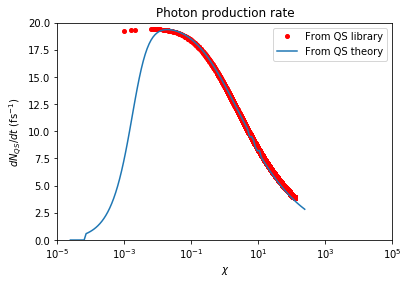

In [83]:
import matplotlib.pyplot as plt

x, y = np.loadtxt('qs_rate.dat', delimiter=' ', unpack=True)
plt.semilogx(x, y, 'ro', label='From QS library', markersize=4)
plt.semilogx(np.array(chilist), np.array(ratelist)*1e-15, label='From QS theory', markersize=2)

plt.xlabel('$\chi$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
plt.ylim(1e-3, 2e1)
plt.xlim(1e-5,1e5)
plt.show()

In [28]:


def KK(chi_ele):
    return integ.quad(lambda s: KK_integ(chi_ele, s), 0.001, chi_ele, limit=400)[0] 

KK = np.vectorize(KK)

frac = [0.01,0.1,0.9]
chi = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
       
for cchi in chi :
    for ffrac in frac :
        print(KK_integ(cchi, cchi*ffrac))
    print("")
    
frac = np.logspace(-5, 1.0, num=1000, base=10)
res = KK_integ(10.0, 10.0*frac)


import matplotlib.pyplot as plt
plt.semilogx(frac*0.09, res, 'ro', label='From BW library', markersize=4)
plt.show()




0.11586593933804681
1.84794209562732e-31
0.0

21.82693639032425
0.005651238787235672
2.268551951683091e-260

20.55416605907147
1.9245303609391278
2.3760791806172353e-26

10.74503711441692
1.920678223127885
0.002174633871030589

5.108747823281633
1.0120166029693047
0.1717705431703861

2.3834091215328597
0.4818744514855814
0.12424034937159859

1.1074943786268197
0.224880240601137
0.06002247759561616



/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 640x480 with 1 Axes>

In [30]:
momx = np.logspace(-3, 5.0, num=200)
chis = []
for mm in momx:
    chis.append(calc_chi_elec(np.array([mm,0,0]),np.array([0, 0, 0]), np.array([0, 0, 500])))

tcoeff = fine_structure_constant*fine_structure_constant/tau_e
th_rates = tcoeff*KK(np.array(chis))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  


NameError: name 'th_rates' is not defined

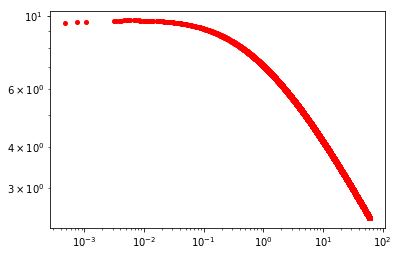

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('qs_rate.dat', delimiter=' ', unpack=True)
plt.loglog(x, y, 'ro', label='From QS library', markersize=4)
plt.loglog(chis, th_rates*1e-15, label='From QS theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
#plt.ylim(1e-5, 1)
#plt.xlim(1e-2,1e3)
plt.show()

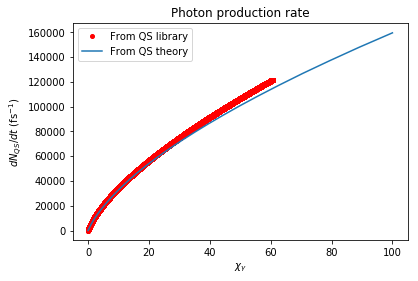

In [52]:
plt.plot(x, y, 'ro', label='From QS library', markersize=4)
plt.plot(chis, th_rates*1e-15, label='From QS theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
#plt.ylim(1e-5, 1)
#plt.xlim(1e-2,1e3)
plt.show()

In [ ]:
print(tau_e)